In the previous notebook titled `Scraping_movie_info_from_IMDb_and_Wikipedia_pages` we scraped movie information for top 250 rated movies on the IMDb website. Now, in this notebook, we will focus on discovering the latent topics present in their plots.

In [1]:
# Import modules
import numpy as np
import pandas as pd
from gensim.models.coherencemodel import CoherenceModel
import gensim
from gensim.models import TfidfModel
import seaborn as sns
import nltk
import random
import scipy

from text_preprocessing_utils import *
from topic_modeling_utils import *

# Setting pandas display options
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 250)

# Set aspects of the visual theme for all matplotlib and seaborn plots.
sns.set_theme()

### Load the movie dataset

In [2]:
# Set seed for reproducibility
#np.random.seed(3)

# Read in IMDb and Wikipedia movie data (both in same file)
movies_df = pd.read_csv('./data/top_250_movies.csv')

print("Number of movies loaded: %s " % (len(movies_df)))

# Display the data
movies_df.head(3)

Number of movies loaded: 250 


,rank,title,genre,release_date,imdb_synopsis,wiki_plot
0,1,The Shawshank Redemption,['Drama'],1994,"In 1947, Andy Dufresne ( Tim Robbins ), a bank...","In 1947 Portland, Maine, banker Andy Dufresne ..."
1,2,The Godfather,"['Crime', 'Drama']",1972,"In late summer 1945, guests are gathered for t...","In 1945 New York City, at his daughter Connie'..."
2,3,The Godfather: Part II,"['Crime', 'Drama']",1974,The Godfather Part II presents two parallel st...,The film intercuts between events some time af...


 In the cell below, we combine movie plots obtained from IMDb and Wikipedia pages into one plot. They are similar, but also contain unique information about the movie plot for each movie, which can gives us a better insight into the movie storyline.

In [3]:
# Combine imdb_synopsis and wiki_plot into a single column
movies_df['plot'] = movies_df['imdb_synopsis'] + " " + movies_df['wiki_plot']
# Inspect the new DataFrame
movies_df.head()

,rank,title,genre,release_date,imdb_synopsis,wiki_plot,plot
0,1,The Shawshank Redemption,['Drama'],1994,"In 1947, Andy Dufresne ( Tim Robbins ), a bank...","In 1947 Portland, Maine, banker Andy Dufresne ...","In 1947, Andy Dufresne ( Tim Robbins ), a bank..."
1,2,The Godfather,"['Crime', 'Drama']",1972,"In late summer 1945, guests are gathered for t...","In 1945 New York City, at his daughter Connie'...","In late summer 1945, guests are gathered for t..."
2,3,The Godfather: Part II,"['Crime', 'Drama']",1974,The Godfather Part II presents two parallel st...,The film intercuts between events some time af...,The Godfather Part II presents two parallel st...
3,4,The Dark Knight,"['Action', 'Crime', 'Drama']",2008,The movie begins with a gang of men with clown...,A gang of criminals rob a Gotham City mob bank...,The movie begins with a gang of men with clown...
4,5,12 Angry Men,"['Crime', 'Drama']",1957,"In a New York City courthouse, an eighteen-yea...",In the overheated jury room of the New York Co...,"In a New York City courthouse, an eighteen-yea..."


Next, we will choose 5 movies at random to set aside, so we can demonstrate predictions on the
unseen data in the last part of the notebook

In [4]:
# Setting aside 5 movies at random
random.seed(55)
movie_indices = list(range(250))
random.shuffle(movie_indices)
print('Movies with the following ranks will be set aside: ',
      np.array(movie_indices[:5]) +1)

# Movies set aside
movies_new_df = movies_df.iloc[movie_indices[:5], :]
print('Movies set aside: ', list(movies_new_df['title']))

# Movies to be used for training
movies_df_train = movies_df.drop(movie_indices[:5], axis=0).reindex()
print('Number of movies available for training: ', len(movies_df_train))

Movies with the following ranks will be set aside:  [230  74 201  30 218]
Movies set aside:  ['Andrei Rublev', 'Aliens', 'The Passion of Joan of Arc', 'Parasite', 'Logan']
Number of movies available for training:  245


### Dataset preprocessing

We will later build topic models to find the most prominent latent topics based on their storylines, but first we need to prepare our dataset.

To begin with, we use our imported function `preprocess_text` from `text_preprocessing_utils.py`. This function allows us to do the following preprocessing steps: it removes special characters and punctuation, replaces accented characters with non-accented ones, replaces hyphenated compounds (e.g. co-operate with cooperate), keeps only tokens that are words and finally removes any stopwords.

Then we apply function `lemmatize_text` also from `text_preprocessing_utils.py`, which extracts the lemma for each token if a token postag is in allowed_postags. We set allowed_postags to the default value which is ['NOUN', 'ADJ', 'VERB', 'ADV'].

In [5]:
# Print bellow the example of one sentence of the movie plot 
# before and after it was fully preprocessed.
print(nltk.sent_tokenize(movies_df_train["plot"][5])[0], '\n')
print(lemmatize_text(preprocess_text(nltk.sent_tokenize(movies_df_train["plot"][5])[0])))

The relocation of Polish Jews from surrounding areas to Krakow begins in late 1939, shortly after the outbreak of World War II, when the German Army defeats the Polish Army in three weeks. 

['relocation', 'polish', 'surround', 'area', 'begin', 'late', 'shortly', 'outbreak', 'german', 'army', 'defeat', 'polish', 'army', 'week']


In [6]:
# Clean the movie plot by applying preprocessing function and
# lemmatization. `Norm documents` is a list of list of normed tokens
# of length which is equal to the number of movies.
norm_documents = [
    lemmatize_text(preprocess_text(x)) for x in movies_df_train['plot']
]
print(len(norm_documents))

245


### Build movie corpus and dictionary

In the code below we are invoking function `prepare_corpus` imported from `topic_modeling_utils.py'. This function builds ngrams for us. The degree of ngrams built is controlled by ngram_value, which is set in this case to 3. That means that we will beside ungrams, also have bigrams and trigrams built. Then it builds term dictionary and documents corpus which are returned to us by this function and which are necessary to be able to use gensim topic models.

In [7]:
# build dictionary and document corpus
dictionary, nn_corpus = prepare_corpus(norm_documents, min_count=10,
                                       threshold=10, ngram_value=3, 
                                       save_ngram_models=True)
print(dictionary)

Dictionary(17099 unique tokens: ['able', 'accord', 'account', 'act', 'action']...)


Next, we use `.filter_extremes` function to reduce the size of our dictionary. We are removing all the terms that our present in more then 80% movie plots and that occur in less than 10 movie plots. Note, that no_below function argument expects positive integer value, while no_above expect a float value between 0 and 1.

In [8]:
# Filter out words that occur in less than 10 movie plots
#or in more than 80% of the movie plots.
dictionary.filter_extremes(no_below=10, no_above=0.8)
print('Total Vocabulary Size:', len(dictionary))
print('Word to number mappings in a dictionary:', list(dictionary.items()))

Total Vocabulary Size: 2760
Word to number mappings in a dictionary: [(0, 'able'), (1, 'accord'), (2, 'account'), (3, 'act'), (4, 'action'), (5, 'actress'), (6, 'actual'), (7, 'address'), (8, 'adjust'), (9, 'admit'), (10, 'adult'), (11, 'advise'), (12, 'afterwards'), (13, 'age'), (14, 'ago'), (15, 'agree'), (16, 'alarm'), (17, 'alert'), (18, 'allow'), (19, 'almost'), (20, 'also'), (21, 'angry'), (22, 'announce'), (23, 'answer'), (24, 'anymore'), (25, 'anyway'), (26, 'appear'), (27, 'appreciate'), (28, 'approach'), (29, 'area'), (30, 'arrest'), (31, 'arrival'), (32, 'arrive'), (33, 'aside'), (34, 'ask'), (35, 'assault'), (36, 'assign'), (37, 'assist'), (38, 'assume'), (39, 'attack'), (40, 'attempt'), (41, 'avoid'), (42, 'away'), (43, 'bad'), (44, 'badly'), (45, 'bag'), (46, 'bank'), (47, 'bar'), (48, 'baseball'), (49, 'basis'), (50, 'bathroom'), (51, 'beach'), (52, 'beam'), (53, 'beat'), (54, 'become'), (55, 'become_increasingly'), (56, 'beer'), (57, 'befriend'), (58, 'behalf'), (59, 'b

In [9]:
# By applying `adjust_tokenized_corpus` function we split the bigrams and
# trigrams, that were removed after we applied `filter_extremes` function
# on our dictionary, to unigrams
norm_corpus = adjust_tokenized_corpus(nn_corpus, dictionary)

# Free memory
del nn_corpus

### Getting Bag of words and TF-IDF representations

Now that we have our dictionary and a movie corpus, we can proceed with building a bag of words and tf_idf representations of the terms contained in our dictionary and viewing the most frequent terms in both representations.

In [10]:
# Transforming corpus into bag of words vectors
bow_corpus = [dictionary.doc2bow(doc) for doc in norm_corpus]
# Viewing actual terms and their counts
bow_df = pd.DataFrame(
    gensim.matutils.corpus2dense(bow_corpus,len(dictionary)).T,
    columns=list(dictionary.values()))
bow_df.head(5)

,able,accord,account,act,action,actress,actual,address,adjust,admit,adult,advise,afterwards,age,ago,agree,alarm,alert,allow,almost,also,angry,announce,answer,anymore,anyway,appear,appreciate,approach,area,arrest,arrival,arrive,aside,ask,assault,assign,assist,assume,attack,attempt,avoid,away,bad,badly,bag,bank,bar,baseball,basis,bathroom,beach,beam,beat,become,become_increasingly,beer,befriend,behalf,behavior,believe,belonging,bet,birth,black,board,book,border,bother,box,break,bribe,brief,bring,brutally,buddy,build,building,bunch,burn,bury,bus,buy,calculate,call,campaign,captain,car,carve,case,cash,catch,cell,charity,chase,cheap,check,chief,choice,city,...,lunch,opinion,romantic,slight,weekend,whistle,yellow,amputate,bang,bone,boot,comply,gesture,grass,infant,nation,nice,overhead,pen,say_goodbye,suspicion,tough,toy,unharmed,vault,foil,prefer,curtain,fearful,mansion,mrs,whisper,brave,casually,chant,echo,feel_guilty,get_ready,hesitant,reconcile,royal,shadow,singing,standing,gunshot,offensive,peer,teen,tooth,attempt_suicide,butler,replacement,mass,pit,anonymous,chat,goal,romance,undercover,opera,ambitious,coach,winter,fog,somehow,spanish,brush,magazine,passionate,purpose,discovery,executive,pet,ditch,junior,alcohol,western,article,proud,university,writer,female,henchman,winner,wine,brawl,depressed,classmate,british,host,mix,commotion,national,north,shortly_thereafter,sit_alone,uncomfortable,neighbour,outfit,blanket
0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,3.0,1.0,1.0,1.0,5.0,2.0,1.0,5.0,2.0,7.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,2.0,1.0,2.0,1.0,20.0,3.0,3.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,5.0,4.0,1.0,2.0,3.0,1.0,1.0,3.0,1.0,2.0,1.0,2.0,2.0,7.0,1.0,1.0,1.0,6.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0,4.0,2.0,1.0,1.0,15.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,8.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,5.0,0.0,10.0,0.0,1.0,0.0,0.0,0.0,7.0,1.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4.0,4.0,0.0,0.0,1.0,0.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,4.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,6.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,6.0,0.0,0.0,0.0,0.0,4.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,6.0,0.0,0.0,6.0,0.0,3.0,0.0,3.0,2.0,0.0,0.0,6.0,1.0,0.0,2.0,1.0,0.0,18.0,1.0,11.0,

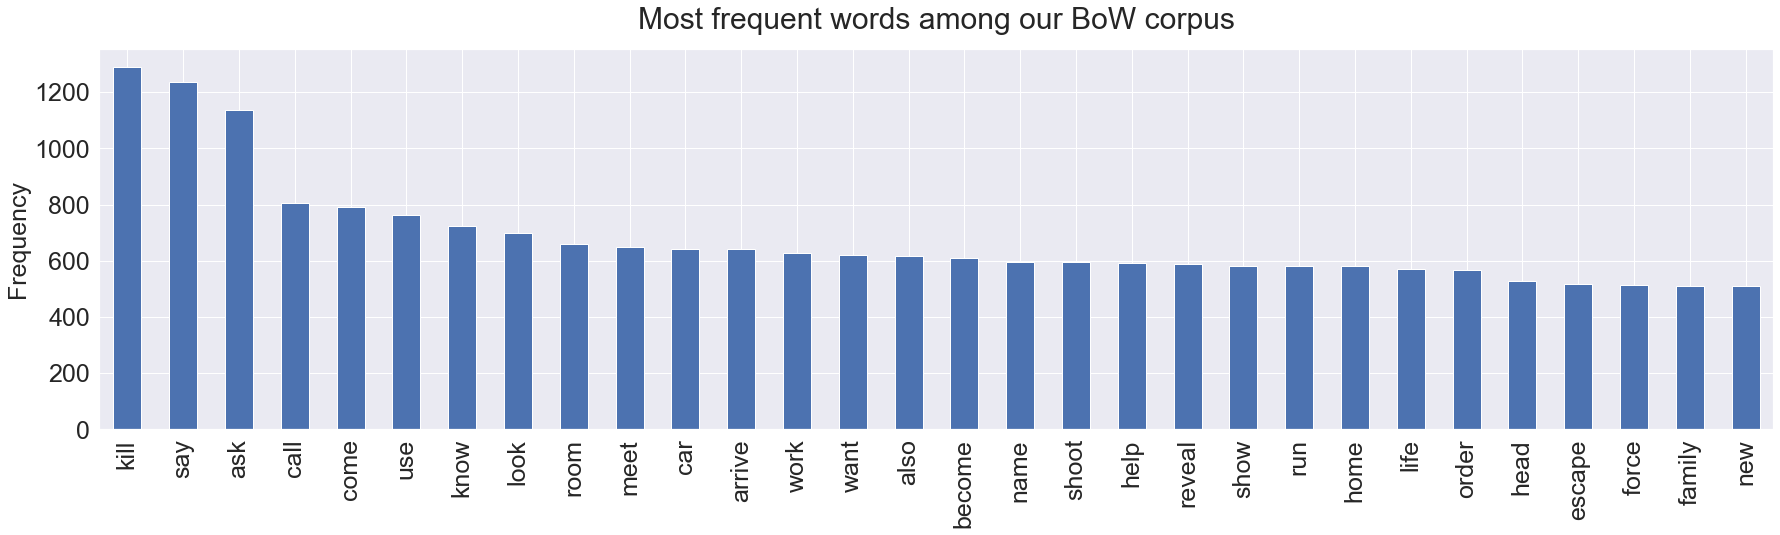

In [11]:
most_frequent_words = np.sum(bow_df, axis=0).sort_values(ascending=False)[:30]
most_frequent_words.plot.bar(figsize=(30, 7), fontsize=25)
plt.title('Most frequent words among our BoW corpus', fontsize=30, pad=20.)
plt.ylabel('Frequency', fontsize=25);

In [12]:
# Getting TF-IDF feature matrix
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]
# Viewing actual terms and their TF-IDF values 
tfidf_df = pd.DataFrame(
    gensim.matutils.corpus2dense(tfidf_corpus, len(dictionary)).T,
    columns=list(dictionary.values()))
tfidf_df.head(5)

,able,accord,account,act,action,actress,actual,address,adjust,admit,adult,advise,afterwards,age,ago,agree,alarm,alert,allow,almost,also,angry,announce,answer,anymore,anyway,appear,appreciate,approach,area,arrest,arrival,arrive,aside,ask,assault,assign,assist,assume,attack,attempt,avoid,away,bad,badly,bag,bank,bar,baseball,basis,bathroom,beach,beam,beat,become,become_increasingly,beer,befriend,behalf,behavior,believe,belonging,bet,birth,black,board,book,border,bother,box,break,bribe,brief,bring,brutally,buddy,build,building,bunch,burn,bury,bus,buy,calculate,call,campaign,captain,car,carve,case,cash,catch,cell,charity,chase,cheap,check,chief,choice,city,...,lunch,opinion,romantic,slight,weekend,whistle,yellow,amputate,bang,bone,boot,comply,gesture,grass,infant,nation,nice,overhead,pen,say_goodbye,suspicion,tough,toy,unharmed,vault,foil,prefer,curtain,fearful,mansion,mrs,whisper,brave,casually,chant,echo,feel_guilty,get_ready,hesitant,reconcile,royal,shadow,singing,standing,gunshot,offensive,peer,teen,tooth,attempt_suicide,butler,replacement,mass,pit,anonymous,chat,goal,romance,undercover,opera,ambitious,coach,winter,fog,somehow,spanish,brush,magazine,passionate,purpose,discovery,executive,pet,ditch,junior,alcohol,western,article,proud,university,writer,female,henchman,winner,wine,brawl,depressed,classmate,british,host,mix,commotion,national,north,shortly_thereafter,sit_alone,uncomfortable,neighbour,outfit,blanket
0,0.011486,0.015226,0.036613,0.006861,0.008400,0.019769,0.016101,0.010034,0.039537,0.005873,0.015505,0.03376,0.011716,0.009791,0.014454,0.020767,0.026681,0.013549,0.020767,0.018225,0.012640,0.008210,0.027993,0.008497,0.013763,0.014454,0.005189,0.020964,0.014034,0.009221,0.013876,0.011716,0.003824,0.016421,0.030593,0.032886,0.038830,0.025506,0.010416,0.004463,0.005917,0.017192,0.004485,0.008596,0.012569,0.010286,0.041957,0.007846,0.020964,0.020964,0.012214,0.017486,0.061017,0.032096,0.006119,0.018306,0.040678,0.042647,0.019244,0.012943,0.008750,0.018758,0.037517,0.016421,0.017392,0.021366,0.07111,0.017486,0.019769,0.012214,0.016024,0.031010,0.011253,0.002671,0.015226,0.019244,0.014835,0.008798,0.020339,0.007935,0.012943,0.014701,0.012982,0.020964,0.003969,0.019244,0.011558,0.010982,0.081356,0.017192,0.012044,0.004516,0.191298,0.020964,0.006938,0.018758,0.019582,0.012389,0.012044,0.007586,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.026125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010077,0.000000,0.00000,0.000000,0.000000,0.000000,0.028505,0.000000,0.000000,0.007126,0.000000,0.024785,0.014087,0.000000,0.014580,0.000000,0.000000,0.008903,0.000000,0.016053,0.015821,0.000000,0.000000,0.016405,0.000000,0.026246,0.000000,0.022208,0.000000,0.000000,0.000000,0.035532,0.014749,0.015392,0.000000,0.000000,0.000000,0.000000,0.013463,0.000000,0.000000,0.020957,0.000000,0.000000,0.044057,0.010498,0.000000,0.000000,0.024391,0.000000,0.022208,0.015013,0.000000,0.000000,0.028175,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.032077,0.000000,0.000000,0.004582,0.026125,0.000000,0.012727,0.015095,0.000000,0.000000,0.000000,0.000000,0.022274,0.000000,0.010214,0.000000,0.079327,0.065950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021257,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

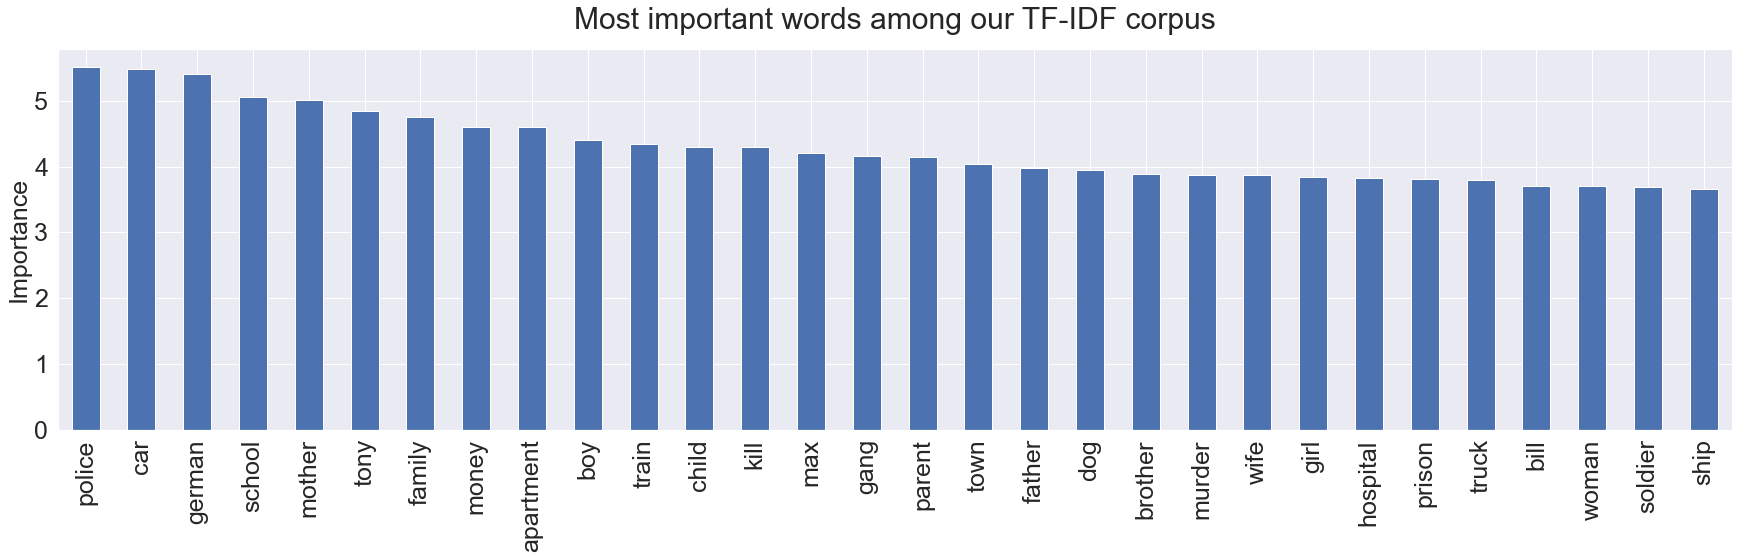

In [13]:
most_frequent_words_tfidf = np.sum(tfidf_df, axis=0).sort_values(ascending=False)[:30]
most_frequent_words_tfidf.plot.bar(figsize=(30, 7), fontsize=25)
plt.title('Most important words among our TF-IDF corpus', fontsize=30, pad=20.)
plt.ylabel('Importance', fontsize=25);

In [14]:
# Free memory
del tfidf_df, bow_df

### Topic modeling

#### Latent Direchlet Allocation with Mallet

Latent Direchlet Allocation is a great algorithm for topic modeling. I chose the Mallet version, because it's based on Collapsed Gibbs sampling which is slower implementation but gives, in most cases, a better solution compared to variational implementations available in scikit-learn and gensim packages. Since, our dataset is small, we can afford to choose mallet implementation.

We will start by running through lda models with different number of clusters and calculating 'c_v' coherence scores for each model. Since our data is small, coherence values can very a lot for different seeds, so we will run each model 3 times with different seeds and choose the highest score achieved for each number of clusters. Then, we will plot the data obtained. Lastly, we will choose model with highest achieved coherence score.

In [15]:
# Finding the optimal number of topics
START = 5
STOP = 25
STEP = 2
N_STEPS = 3

# For reproducibility purposes
SEED_LIST = [3, 6, 44]

all_models_list = []
all_coherence_values_list = []
for i in range(N_STEPS):
    model_list, coherence_values_list = compute_coherence_values(
        bow_corpus, dictionary, norm_corpus, 'c_v', START, STOP, STEP,
        'lda_mallet',iterations=300, seed=SEED_LIST[i])
    all_models_list.append(model_list)
    all_coherence_values_list.append(coherence_values_list)

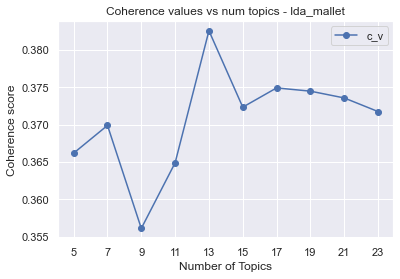

In [16]:
# Ploting coherence values vs number of topics graph
plot_coherence_values_vs_num_topics(np.max(all_coherence_values_list, axis=0),
                                    START, STOP, STEP, 'c_v', ' - lda_mallet')

In [17]:
best_lda_mallet_model = all_models_list[0][4]
print('Achieved coherence value for the best model: ', all_coherence_values_list[0][4])

Achieved coherence value for the best model:  0.3825436841736043


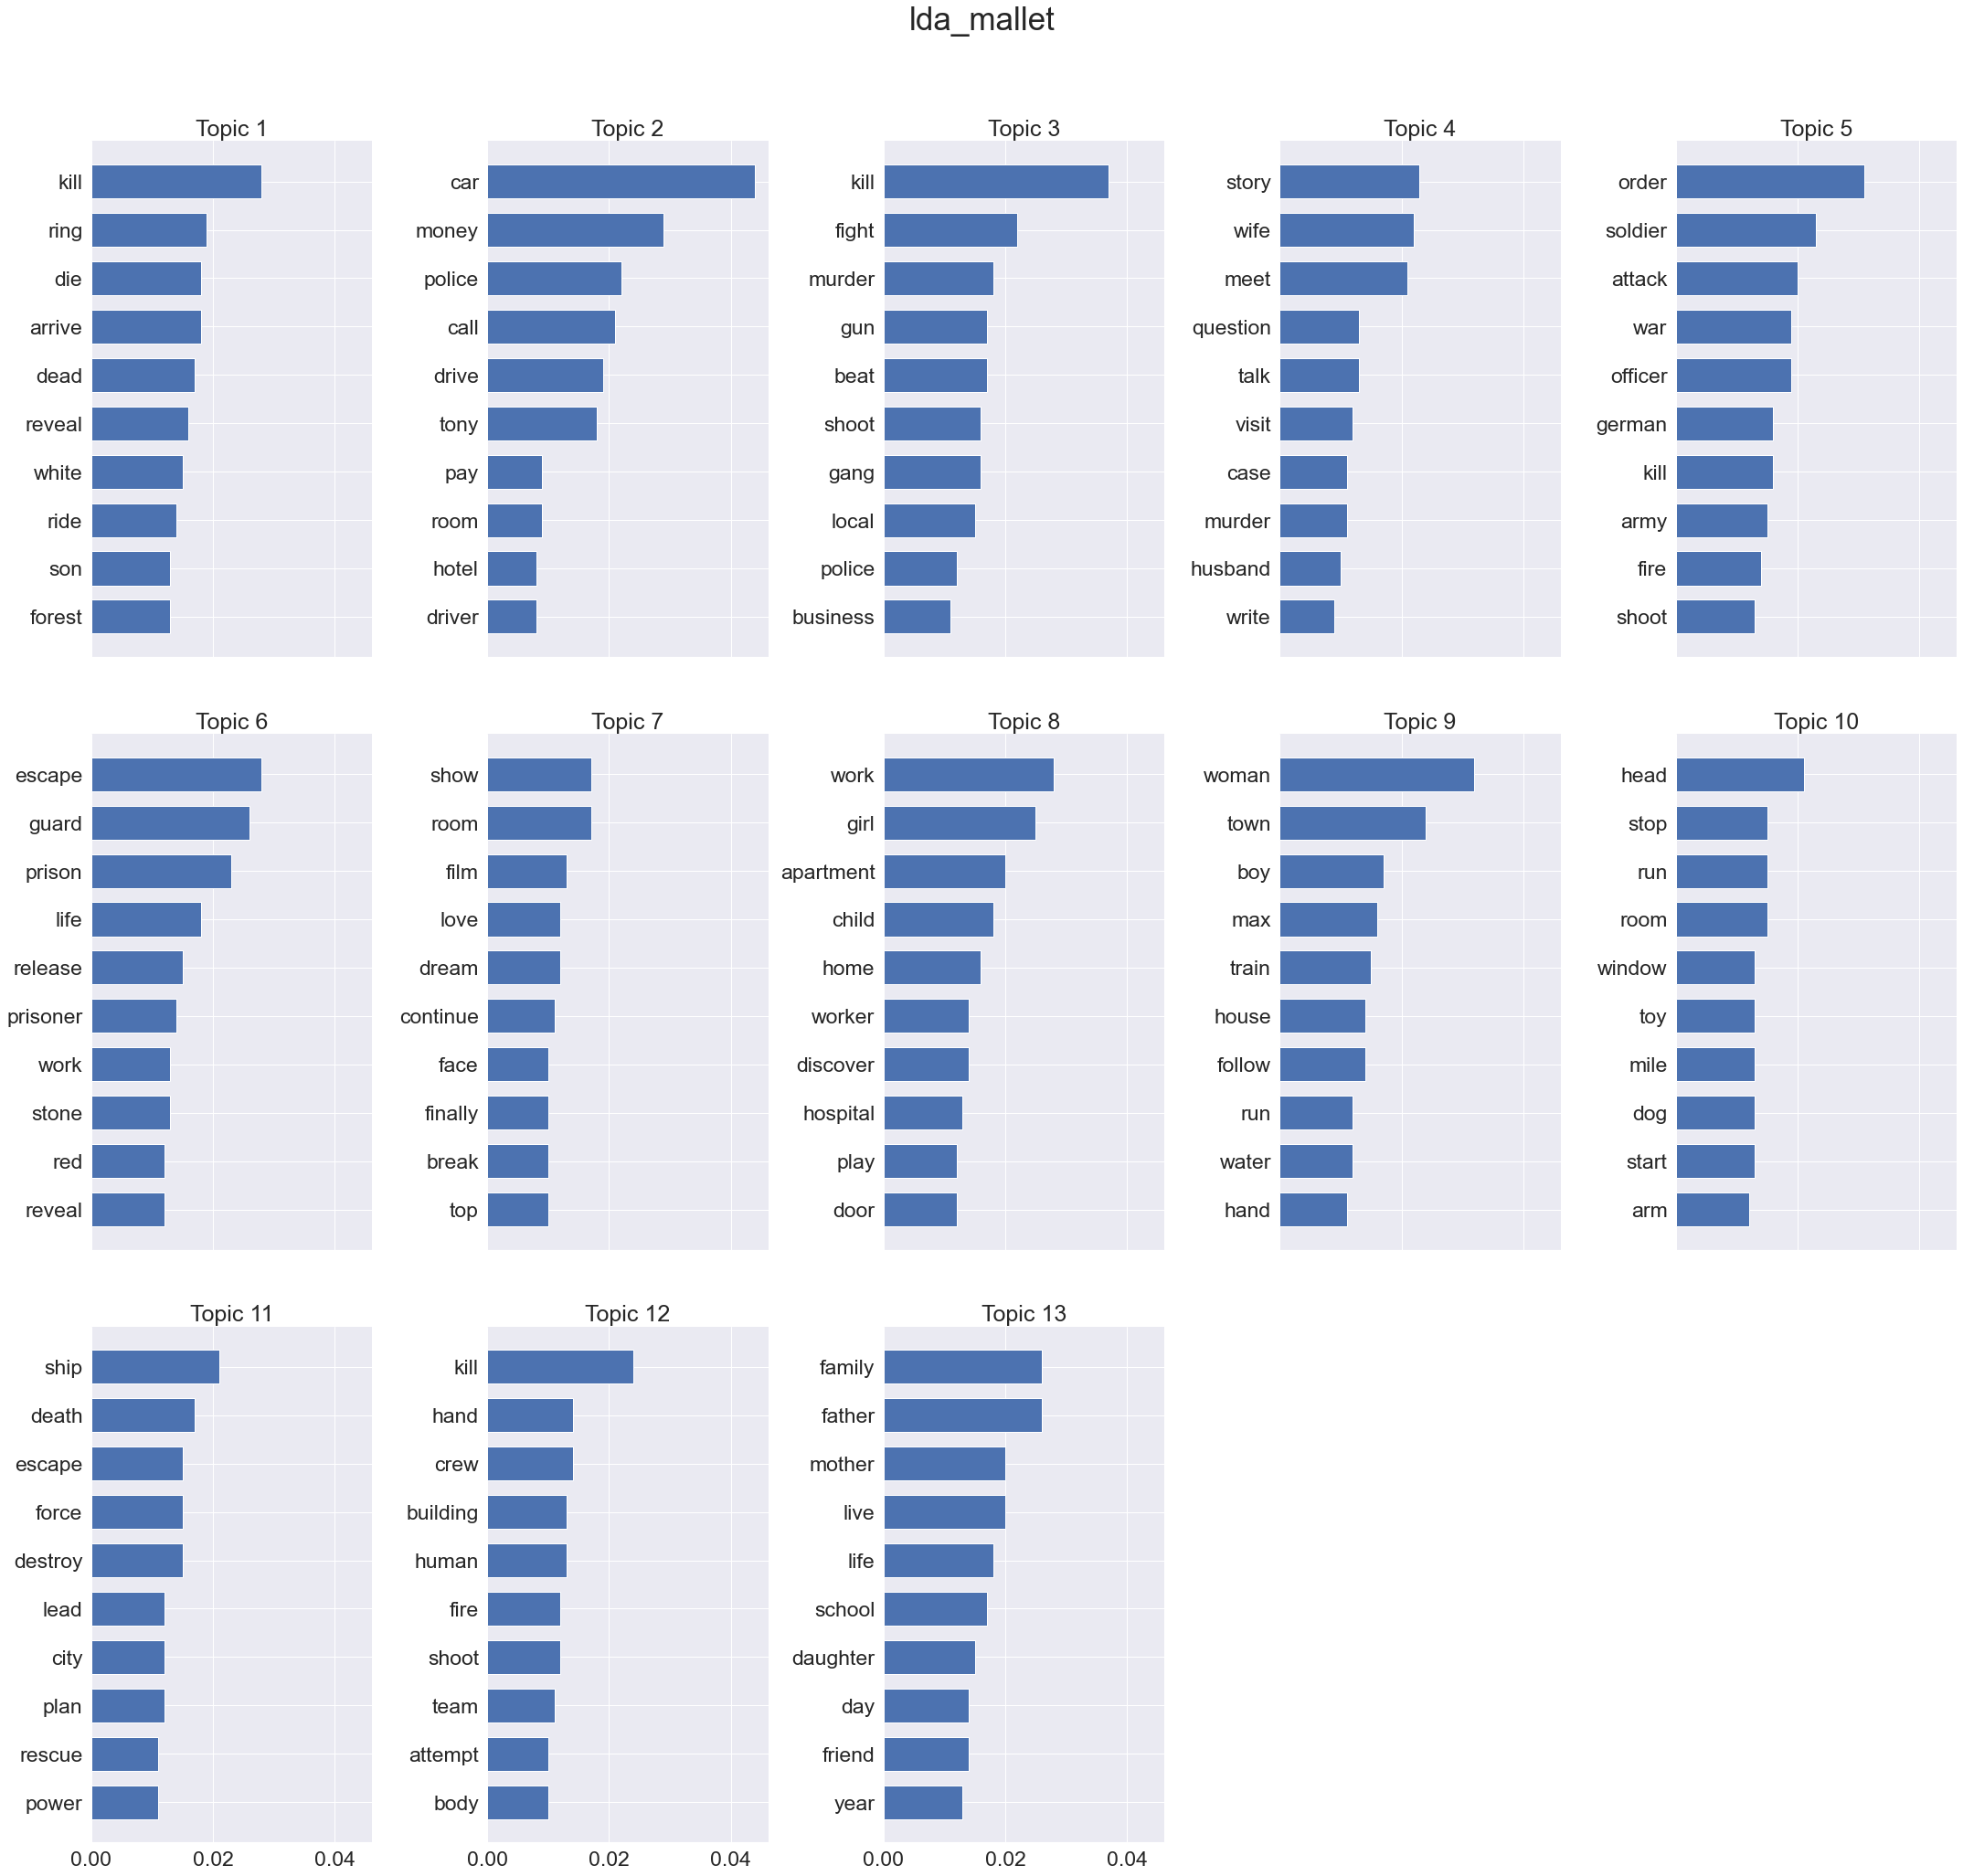

In [18]:
# Plotting top terms and their weights for the best lda model
top_terms, weights = get_topn_words_and_weights_gensim_model(
    best_lda_mallet_model, n_top_terms=10)
plot_top_words(top_terms, weights, 'lda_mallet')

As we look at the above topics, we can notice that some of them are easy to understand like topic 5 which is war related or topic 6 which is prison related. Some of them are harder to interpret, like topic 1 for example. So let's see which movie is the most representative for each topic, and for which movies each topic is the dominant one so we can better understand the topics.

In [19]:
# Retrieve movie_topic matrix and show it below

# Table styling options
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

num_topics = 13
movie_topic_matrix = np.array(best_lda_mallet_model[bow_corpus])[:, :, 1]
columns = ['topic_' +str(i+1) for i in range(num_topics)]

pd.DataFrame(movie_topic_matrix, columns=columns).head().style.applymap(color_green).applymap(make_bold)

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13
0,0.018687,0.078556,0.062251,0.103400,0.013166,0.442686,0.049052,0.026192,0.025588,0.065270,0.025329,0.016357,0.073466
1,0.029249,0.074694,0.313281,0.120660,0.066877,0.070004,0.045613,0.020181,0.017679,0.034565,0.025497,0.046447,0.135253
2,0.047422,0.067852,0.320361,0.101902,0.056741,0.046347,0.067315,0.052619,0.031652,0.021795,0.038282,0.029680,0.118031
3,0.024282,0.083240,0.213165,0.067628,0.026340,0.074491,0.068944,0.042867,0.031659,0.090617,0.063625,0.190691,0.022452
4,0.044094,0.015102,0.063078,0.361680,0.016720,0.034822,0.147552,0.087213,0.046890,0.053365,0.024226,0.037029,0.068229


In [20]:
# Adjusting pandas display options
pd.set_option("max_colwidth", 400)

# Retrieving dominanat topic per movie
dominant_topic_per_movie = pd.DataFrame(
    np.argmax(movie_topic_matrix.T, axis=0) + 1,
    columns=['dominant topic'], index=movies_df_train.index)

# Creating pandas dataframe where each row represnts a topic with the most
# important information
N_MOVIES = 250
topics_df = pd.DataFrame()
topics_df['topic_num'] = pd.Series(list(range(1, num_topics+1)))
topics_df['dominant_in_nmovies'] = np.unique(
    np.argmax(movie_topic_matrix.T, axis=0) + 1,  return_counts=True)[1]
topics_df['dominant_in_%_total_movies'] = (
    topics_df['dominant_in_nmovies']/N_MOVIES).round(4) * 100
topics_df['topic_top_10_words'] = top_terms
topics_df['most_representative_movie'] = list(
    movies_df_train.iloc[np.argmax(movie_topic_matrix, axis=0)]['title'])
topics_df['movies_dominated_by_this_topic'] = [
    list(movies_df_train[dominant_topic_per_movie['dominant topic']==n]['title'])
    for n in range(1, num_topics+1)]

topics_df

,topic_num,dominant_in_nmovies,dominant_in_%_total_movies,topic_top_10_words,most_representative_movie,movies_dominated_by_this_topic
0,1,14,5.6,"[kill, ring, die, arrive, dead, reveal, white, ride, son, forest]",The Lord of the Rings: The Fellowship of the Ring,"[The Lord of the Rings: The Return of the King, The Good, the Bad and the Ugly, The Lord of the Rings: The Fellowship of the Ring, The Lord of the Rings: The Two Towers, Django Unchained, Princess Mononoke, Reservoir Dogs, Pan's Labyrinth, The Gold Rush, 12 Years a Slave, Ben-Hur, Harry Potter and the Deathly Hallows: Part 2, Into the Wild, The Princess Bride]"
1,2,26,10.4,"[car, money, police, call, drive, tony, pay, room, hotel, driver]",Fargo,"[Pulp Fiction, Léon: The Professional, Back to the Future, Psycho, The Shining, Requiem for a Dream, North by Northwest, Bicycle Thieves, Snatch, Scarface, Heat, Green Book, Some Like It Hot, The Wolf of Wall Street, Lock, Stock and Two Smoking Barrels, No Country for Old Men, Dial M for Murder, The Third Man, Trainspotting, Fargo, Sherlock Jr., Andhadhun, The Big Lebowski, It Happened One Nig..."
2,3,28,11.2,"[kill, fight, murder, gun, beat, shoot, gang, local, police, business]",City of God,"[The Godfather, The Godfather: Part II, The Dark Knight, Goodfellas, City of God, The Usual Suspects, American History X, The Departed, Once Upon a Time in America, Taxi Driver, The Sting, For a Few Dollars More, Yojimbo, Unforgiven, Casino, Raging Bull, Memories of Murder, Warrior, Kill Bill: Vol. 1, On the Waterfront, Gran Torino, Million Dollar Baby, The Bandit, La Haine, Gangs of Wasseypur..."
3,4,22,8.8,"[story, wife, meet, question, talk, visit, case, murder, husband, write]",Spotlight,"[12 Angry Men, Se7en, Memento, Witness for the Prosecution, Citizen Kane, The Hunt, Double Indemnity, A Separation, To Kill a Mockingbird, L.A. Confidential, Rashomon, Judgment at Nuremberg, The Secret in Their Eyes, Three Billboards Outside Ebbing, Missouri, Prisoners, Mr. Smith Goes to Washington, In the Name of the Father, Gone Girl, Spotlight, Rebecca, Before Sunset, Three Colors: Red]"
4,5,24,9.6,"[order, soldier, attack, war, officer, german, kill, army, fire, shoot]",1917,"[Seven Samurai, Saving Private Ryan, Gladiator, Casablanca, Apocalypse Now, The Great Dictator, Paths of Glory, Das Boot, Braveheart, Inglourious Basterds, Come and See, Lawrence of Arabia, Full Metal Jacket, 1917, Ran, Downfall, The Bridge on the River Kwai, The General, The Deer Hunter, Hacksaw Ridge, Platoon, Hotel Rwanda, The Battle of Algiers, Neon Genesis Evangelion: The End of Evangelion]"
5,6,12,4.8,"[escape, guard, prison, life, release, prisoner, work, stone, red, reveal]",The Shawshank Redemption,"[The Shawshank Redemption, Schindler's List, The Silence of the Lambs, Life Is Beautiful, The Green Mile, The Pianist, The Lives of Others, Avengers: Infinity War, Avengers: Endgame, The Great Escape, Cool Hand Luke, Monty Python's Life of Brian]"
6,7,17,6.8,"[show, room, film, love, dream, continue, face, finally, break, top]",Singin' in the Rain,"[Inception, Joker, American Beauty, Vertigo, Singin' in the Rain, A Clockwork Orange, Monty Python and the Holy Grail, Howl's Moving Castle, The Treasure of the Sierra Madre, V for Vendetta, The Truman Show, Finding Nemo, Stalker, Persona, Network, Sunrise, Nights of Cabiria]"
7,8,15,6.0,"[work, girl, apartment, child, home, worker, discover, hospital, play, door]","Monsters, Inc.","[One Flew Over the Cuckoo's Nest, It's a Wonderful Life, Modern Times, City Lights, High and Low, M, Eternal Sunshine of the Spotless Mind, Ikiru, Metropolis, The Apartment, Shutter Island, The Elephant Man, To Be or Not to Be, Monsters, Inc., Hera Pheri]"
8,9,14,5.6,"[woman, town, boy, max, train, house, follow, run, water, hand]",The Handmaiden,"[The Prestige, Once Upon a Time in the West, Sunset Blvd., Your Name., The Kid, There Will Be Blood, My Neighbor Totoro, Chinatown, The Grand Budapest Hotel, Mary and Max, Mad Max: Fury Road, Stand by M

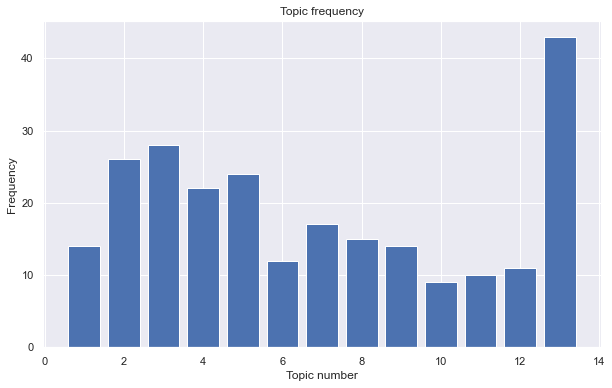

In [21]:
# Plot topic frequency
plt.figure(figsize=(10, 6))
plt.bar(topics_df['topic_num'], topics_df['dominant_in_nmovies'])
plt.title('Topic frequency')
plt.xlabel('Topic number')
plt.ylabel('Frequency')
plt.show()

In [22]:
from sklearn.manifold import TSNE
# Fit TSNE model
tsne_model = TSNE(n_components=2, verbose=0, random_state=2, angle=.99, init='pca')
X_tsne =  tsne_model.fit_transform(movie_topic_matrix)

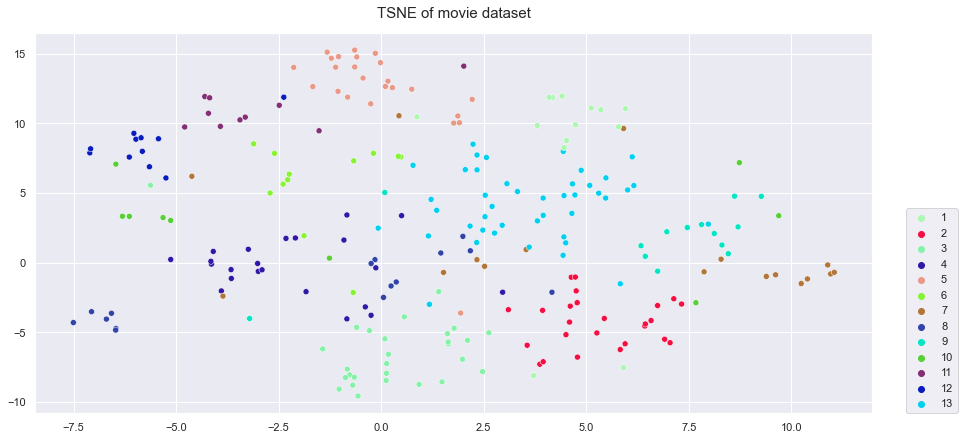

In [23]:
def generate_color():
    color = "#{:02x}{:02x}{:02x}".format(
        *map(lambda x: random.randint(0, 255), range(3)))
    return color

# Create colormap
colormap = list([generate_color() for t in range(num_topics)])

# Create a plot
plt.figure(figsize=(15, 7))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1],
                hue=dominant_topic_per_movie['dominant topic'],
                palette=colormap)
plt.title("TSNE of movie dataset", fontsize=15, pad=15)
plt.legend(loc=(1.04, 0))
plt.show();

The overlapping topics are due to the movies that don't have a clear dominant topic. We will fit again TSNE model in below cell, but now we will only use movies where probabilities of belonging to one of the topics is greater than 0.25.

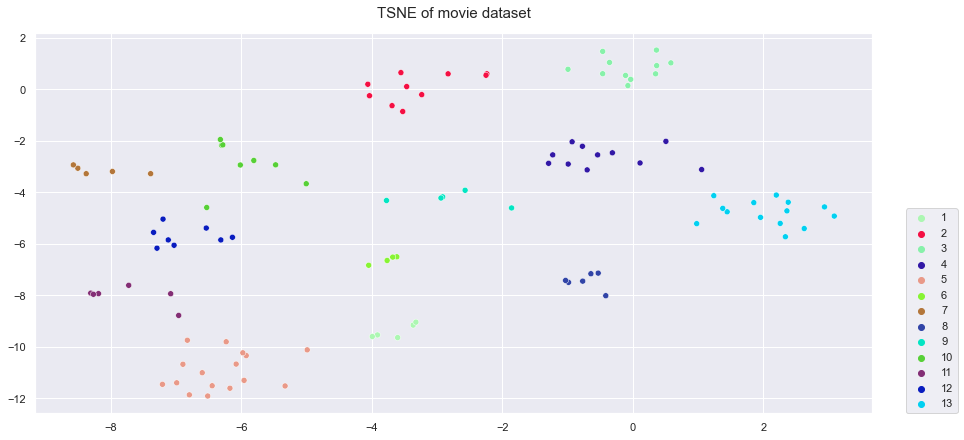

In [24]:
# Keep the well separated points and fit again TSNE on them
idx = np.amax(movie_topic_matrix, axis = 1) >= 0.25
movie_topic_matrix_temp = movie_topic_matrix[idx]

# Fit TSNE model
tsne_model = TSNE(n_components=2, verbose=0, random_state=2, angle=.99, init='pca')
X_tsne_2 =  tsne_model.fit_transform(movie_topic_matrix_temp)

# Create a plot
plt.figure(figsize=(15, 7))
sns.scatterplot(x=X_tsne_2[:,0], y=X_tsne_2[:,1],
                hue=dominant_topic_per_movie.loc[idx, 'dominant topic'],
                palette=colormap)
plt.title("TSNE of movie dataset", fontsize=15, pad=15)
plt.legend(loc=(1.04, 0))
plt.show();

We got a much cleaner topic visualization.

### Other topic models

Other topic models that I want to briefly explore are latent semantic indexing and non-negative matrix factorization.

#### Latent Semantic Indexing with Gensim

We will now fit Latent Semantic Indexing model using the same number of topics which was optimal for the previous model. We will fit it using both bow_corpus and tfidf_corpus and compare obtained coharence values.

In [25]:
from gensim.models import LsiModel
lsi_bow = LsiModel(bow_corpus, id2word=dictionary,
                   num_topics=13, power_iters=10)
top_terms, weights = get_topn_words_and_weights_gensim_model(
    lsi_bow, n_top_terms=20)
coherence_model = CoherenceModel(
                topics=top_terms, texts=norm_corpus, dictionary=dictionary,
                coherence='c_v')
print('Coherence value for lsi_bow model is: ', coherence_model.get_coherence())

Coherence value for lsi_bow model is:  0.21117390454247725


In [26]:
lsi_tfidf = LsiModel(tfidf_corpus, id2word=dictionary,
                   num_topics=13, power_iters=10)
top_terms, weights = get_topn_words_and_weights_gensim_model(
    lsi_tfidf, n_top_terms=20)
coherence_model = CoherenceModel(
                topics=top_terms, texts=norm_corpus, dictionary=dictionary,
                coherence='c_v')
print('Coherence value for lsi_tfidf model is: ', coherence_model.get_coherence())

Coherence value for lsi_tfidf model is:  0.2845322825216866


As we can see coherence values for latent semantic indexing model compared to lda_mallet model are quite lower. Now let's look at the top term and weights for the better performing lsi model of the two.

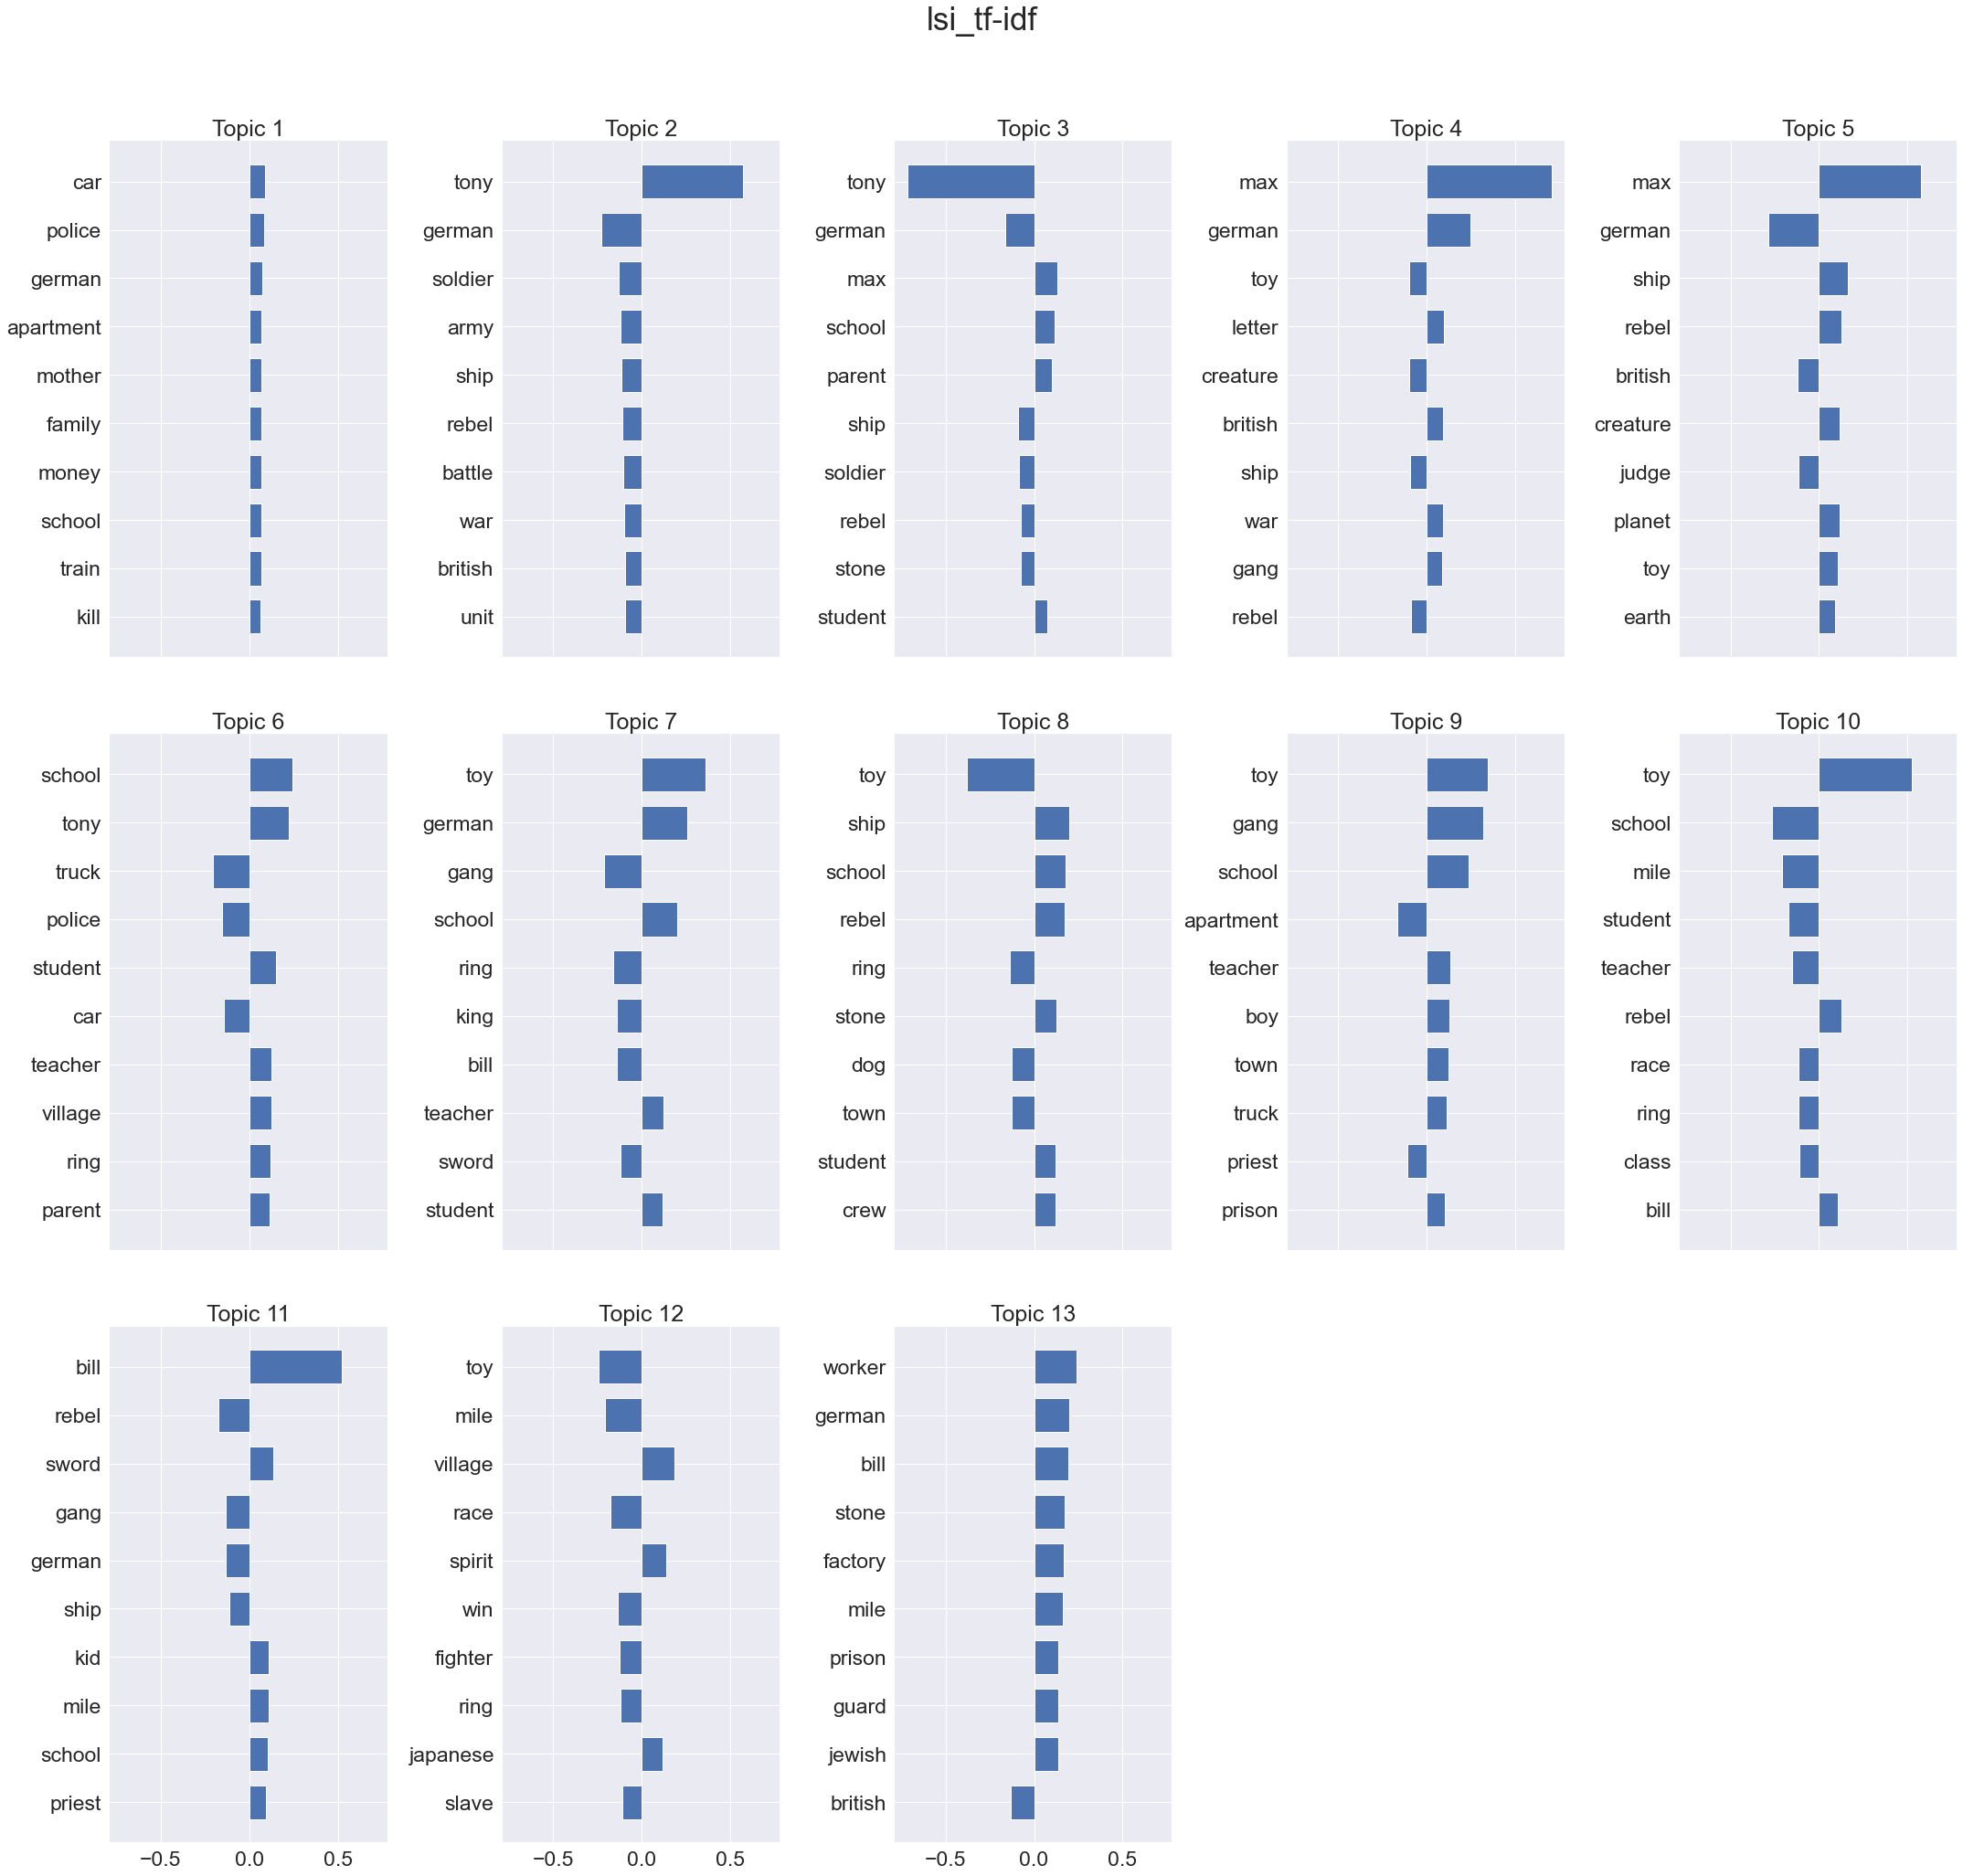

In [27]:
top_terms, weights = get_topn_words_and_weights_gensim_model(
    lsi_tfidf, n_top_terms=10)
plot_top_words(top_terms, weights, 'lsi_tf-idf')

From the above plot, we can see that topics obtained by the LDA model are definitely easier to understand and interpret than for the LSI model, since all the weights are of the same sign and tell us the importance of each term in the topic. Also, we can see that some of the words are present in multiple topics for the LSI model which is not ideal. Overall lda model performs much better in this case.

#### Non-Negative Matrix Factorization

Lastly, we are going to fit non-negative matrix factorization model on our data. This model usually performs beter on the tf_idf representation of dictionary terms, so this is what we are going to use. We will use the same number of topics as for the LDA Mallet model, just to be able to compare the found topics easier, but it would be even better to search for the optimal number of topics in the same way we did for the first model.

In [28]:
from sklearn.decomposition import NMF
TOTAL_TOPICS=13
nmf_model = NMF(n_components=TOTAL_TOPICS, solver='cd', max_iter=3000,
                random_state=44, alpha=.1, l1_ratio=.85)
bow_matrix = gensim.matutils.corpus2dense(bow_corpus, len(dictionary)).T
nmf = nmf_model.fit(bow_matrix)

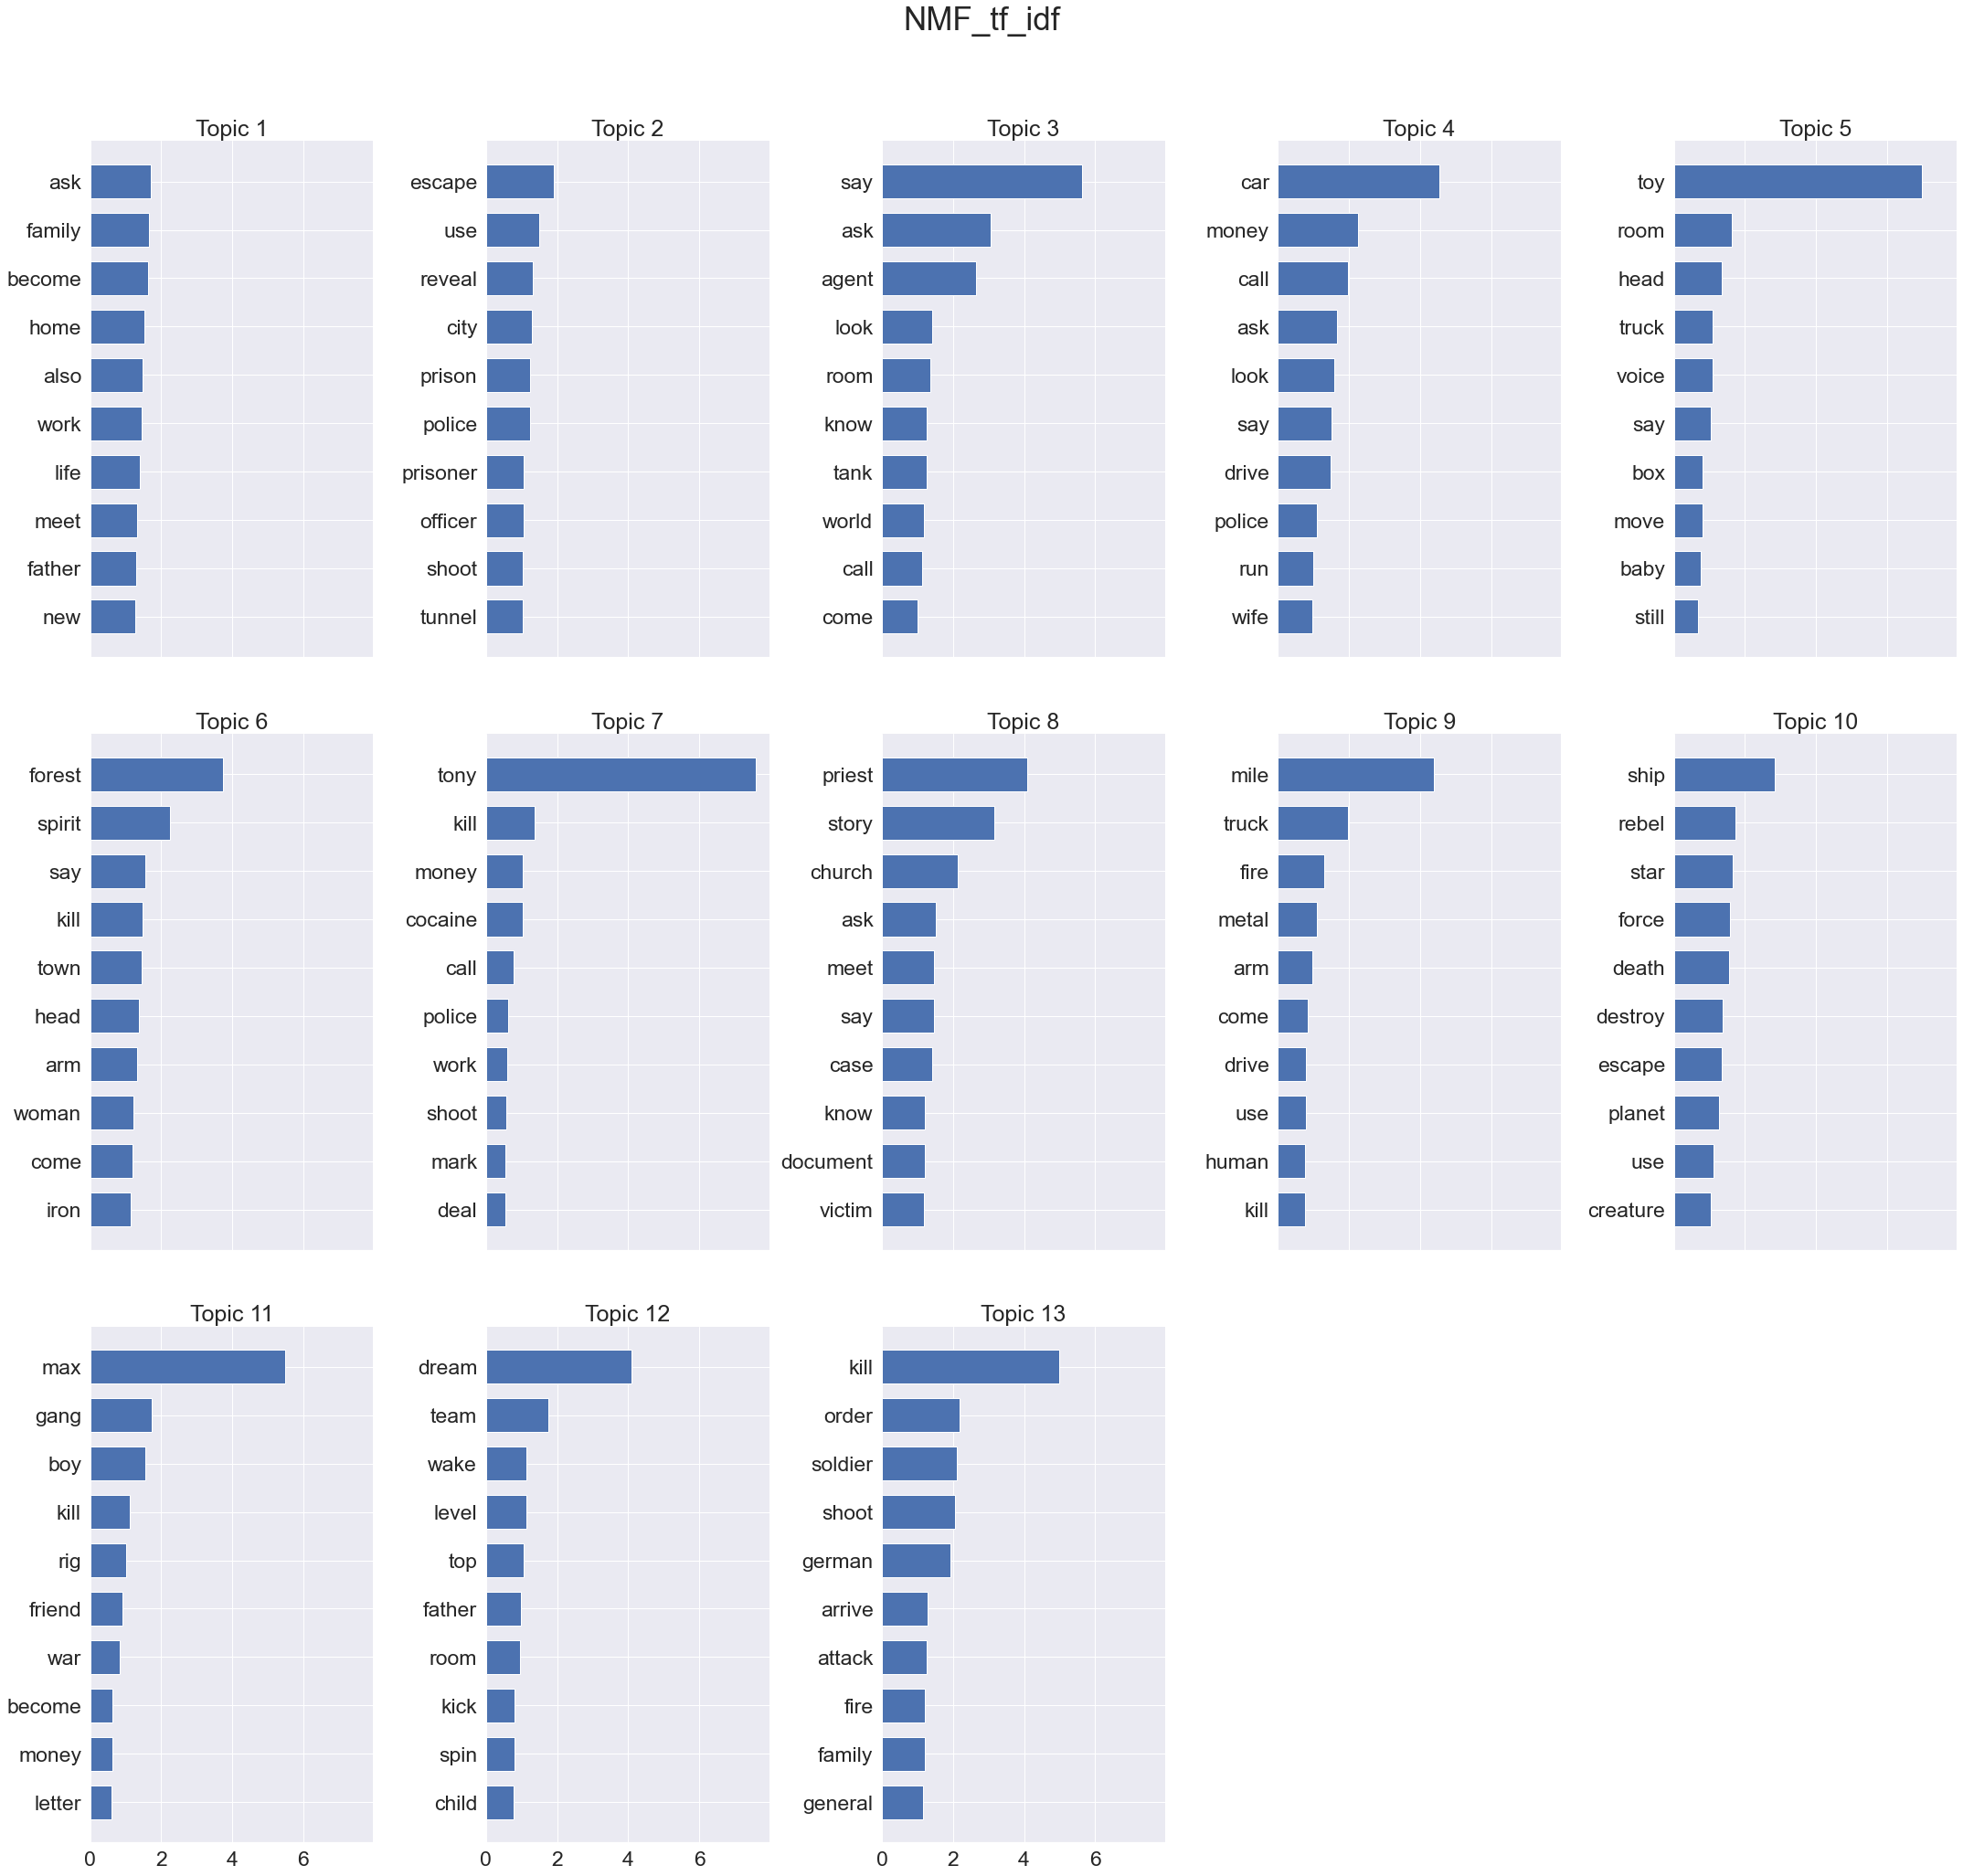

In [29]:
top_terms, weights = \
    get_topn_words_and_weights_scikit_model(nmf, list(dictionary.values()))
plot_top_words(top_terms, weights, 'NMF_tf_idf')

In [30]:
top_termss, weightss = \
    get_topn_words_and_weights_scikit_model(nmf, list(dictionary.values()), 20)
coherence_model = CoherenceModel(topics=top_termss, texts=norm_corpus,
                                 dictionary=dictionary, coherence='c_v')
print(coherence_model.get_coherence())

0.38782856076142547


In [31]:
# Retrieve movie_topic matrix and show it below
num_topics = 13
movie_topic_matrix = nmf.transform(bow_matrix)
movie_topic_matrix

array([[3.7118137 , 3.7259896 , 0.04553805, ..., 0.        , 0.        ,
        0.        ],
       [2.352001  , 0.        , 0.        , ..., 0.        , 0.        ,
        2.7952108 ],
       [1.4575021 , 0.        , 0.16990507, ..., 0.        , 0.        ,
        1.5332023 ],
       ...,
       [0.9129983 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.55601966],
       [1.0005379 , 0.        , 0.        , ..., 0.0800348 , 0.        ,
        0.        ],
       [1.4561551 , 0.        , 0.        , ..., 0.        , 0.41898313,
        0.        ]], dtype=float32)

In [32]:
# Adjusting pandas display options
pd.set_option("max_colwidth", 400)

# Retrieving dominanat topic per movie
dominant_topic_per_movie = pd.DataFrame(
    np.argmax(movie_topic_matrix.T, axis=0) + 1,
    columns=['dominant topic'], index=movies_df_train.index)

# Creating pandas dataframe where each row represnts a topic with the most
# important information
N_MOVIES = 250
topics_df = pd.DataFrame()
topics_df['topic_num'] = pd.Series(list(range(1, num_topics+1)))
topics_df['dominant_in_nmovies'] = np.unique(
    np.argmax(movie_topic_matrix.T, axis=0) + 1,  return_counts=True)[1]
topics_df['dominant_in_%_total_movies'] = (
    topics_df['dominant_in_nmovies']/N_MOVIES).round(4) * 100
topics_df['topic_top_10_words'] = top_terms
topics_df['most_representative_movie'] = list(
    movies_df_train.iloc[np.argmax(movie_topic_matrix, axis=0)]['title'])
topics_df['movies_dominated_by_this_topic'] = [
    list(movies_df_train[dominant_topic_per_movie['dominant topic']==n]['title'])
    for n in range(1, num_topics+1)]

topics_df

,topic_num,dominant_in_nmovies,dominant_in_%_total_movies,topic_top_10_words,most_representative_movie,movies_dominated_by_this_topic
0,1,107,42.8,"[ask, family, become, home, also, work, life, meet, father, new]",The Shawshank Redemption,"[12 Angry Men, Fight Club, Forrest Gump, Goodfellas, It's a Wonderful Life, The Green Mile, The Pianist, Modern Times, American History X, Grave of the Fireflies, Whiplash, The Intouchables, The Prestige, Cinema Paradiso, The Lives of Others, The Shining, Joker, Oldboy, Your Name., Hamilton, Coco, Capharnaüm, High and Low, American Beauty, 3 Idiots, Amadeus, Pather Panchali, Good Will Hunting,..."
1,2,16,6.4,"[escape, use, reveal, city, prison, police, prisoner, officer, shoot, tunnel]",The Dark Knight Rises,"[The Shawshank Redemption, The Dark Knight, One Flew Over the Cuckoo's Nest, Se7en, The Silence of the Lambs, The Departed, Indiana Jones and the Raiders of the Lost Ark, The Dark Knight Rises, M, Indiana Jones and the Last Crusade, Die Hard, Batman Begins, The Great Escape, V for Vendetta, The General, Cool Hand Luke]"
2,3,11,4.4,"[say, ask, agent, look, room, know, tank, world, call, come]",The Matrix,"[The Matrix, Spirited Away, To Kill a Mockingbird, Howl's Moving Castle, Shutter Island, The Third Man, Blade Runner, Room, Gone Girl, The Handmaiden, La Haine]"
3,4,25,10.0,"[car, money, call, ask, look, say, drive, police, run, wife]",Fargo,"[Pulp Fiction, Back to the Future, Psycho, City Lights, Rear Window, Memento, Reservoir Dogs, North by Northwest, The Sting, Snatch, L.A. Confidential, Heat, The Wolf of Wall Street, Lock, Stock and Two Smoking Barrels, No Country for Old Men, Wild Strawberries, Fargo, Sherlock Jr., Andhadhun, The Big Lebowski, Rush, Amores Perros, It Happened One Night, Sunrise, Hera Pheri]"
4,5,3,1.2,"[toy, room, head, truck, voice, say, box, move, baby, still]",Toy Story,"[Toy Story, Toy Story 3, Klaus]"
5,6,5,2.0,"[forest, spirit, say, kill, town, head, arm, woman, come, iron]",Princess Mononoke,"[The Lord of the Rings: The Two Towers, The Lion King, Once Upon a Time in the West, Princess Mononoke, Nausicaä of the Valley of the Wind]"
6,7,5,2.0,"[tony, kill, money, cocaine, call, police, work, shoot, mark, deal]",Scarface,"[Léon: The Professional, Scarface, Green Book, Dial M for Murder, Rififi]"
7,8,2,0.8,"[priest, story, church, ask, meet, say, case, know, document, victim]",Spotlight,"[Rashomon, Spotlight]"
8,9,4,1.6,"[mile, truck, fire, metal, arm, come, drive, use, human, kill]",Terminator 2: Judgment Day,"[Terminator 2: Judgment Day, Spider-Man: Into the Spider-Verse, Ford v Ferrari, The Wages of Fear]"
9,10,19,7.6,"[ship, rebel, star, force, death, destroy, escape, planet, use, creature]",Star Wars: Episode IV - A New Hope,"[The Lord of the Rings: The Return of the King, The Lord of the Rings: The Fellowship of the Ring, Star Wars: Episode V - The Empire Strikes Back, Star Wars: Episode IV - A New Hope, Interstellar, Alien, WALL·E, Avengers: Infinity War, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Das Boot, Avengers: Endgame, Star Wars: Episode VI - Return of the Jedi, 2001: A Space Ody..."


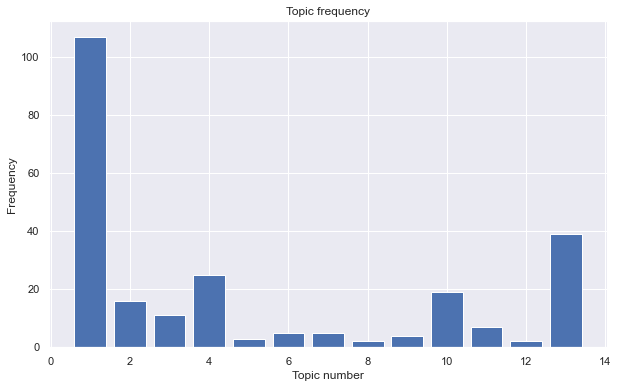

In [33]:
# Plot topic frequency
plt.figure(figsize=(10, 6))
plt.bar(topics_df['topic_num'], topics_df['dominant_in_nmovies'])
plt.title('Topic frequency')
plt.xlabel('Topic number')
plt.ylabel('Frequency')
plt.show()

We can notice from the above graph that topics are much more evenly distributed among the movies in LDA model than in the NMF model. 

### Make topic predictions on unseen data

First we need to preprocess our unseen data in the same way as we did our training data.

In [34]:
from gensim.models.phrases import Phraser

In [35]:
# Go through preprocessing step
norm_documents_new = [
    lemmatize_text(preprocess_text(x)) for x in movies_new_df['plot']
]
print('Number of movies in unseen data: ', len(norm_documents_new))

bigram_model = Phraser.load('./ngram_models/ngram_model1.pkl')
trigram_model = Phraser.load('./ngram_models/ngram_model2.pkl')
nn_corpus_new = list(trigram_model[bigram_model[norm_documents_new]])

# By applying `adjust_tokenized_corpus` function we split the bigrams and
# trigrams, that were removed after we applied `filter_extremes` function
# on our dictionary, to unigrams
norm_corpus_new = adjust_tokenized_corpus(nn_corpus_new, dictionary)

# Free memory
del nn_corpus_new

Number of movies in unseen data:  5


In [36]:
# Transforming corpus into bag of words vectors
bow_corpus_new = [dictionary.doc2bow(doc) for doc in norm_corpus_new]
bow_matrix_new = gensim.matutils.corpus2dense(bow_corpus_new, len(dictionary)).T

In [37]:
# Get our model estimates for our unseen movies
movie_topic_lda = np.array(best_lda_mallet_model[bow_corpus_new])[:, :, 1]
movie_topic_nmf = nmf.transform(bow_matrix_new)

In [38]:
top_terms_lda, weights_lda = get_topn_words_and_weights_gensim_model(
    best_lda_mallet_model, n_top_terms=10)
labels_lda = ['topic_' + str(i) + ': ' + str(top_terms_lda[i]) for i in range(13)]

We can visualize the topics distribution for each new movie using stack plot.

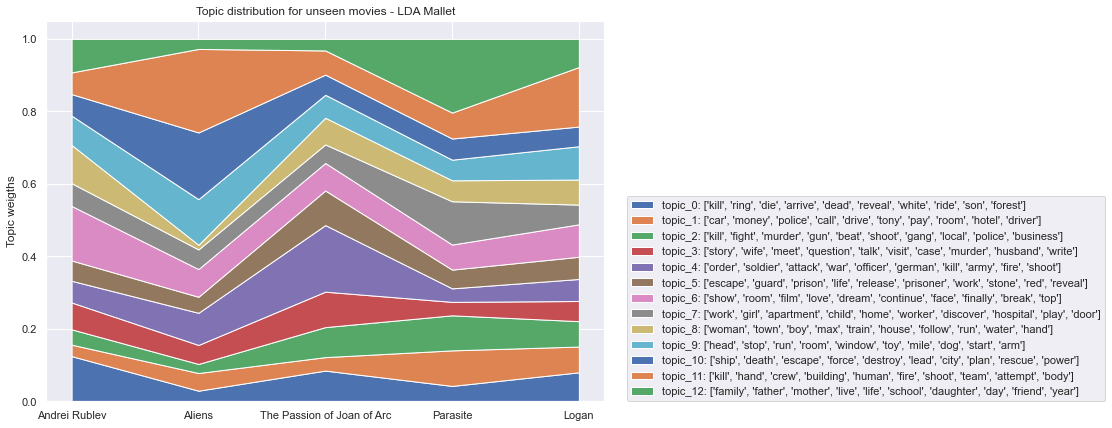

In [39]:
x_axis = list(movies_new_df['title'])
y_axis = movie_topic_lda
fig, ax = plt.subplots(figsize=(10, 7))
ax.stackplot(x_axis, y_axis.T, baseline='zero', labels=labels_lda)
ax.set_ylabel('Topic weigths')
plt.title('Topic distribution for unseen movies - LDA Mallet')
# Move the legend off of the chart
ax.legend(loc=(1.04, 0));

In [40]:
top_terms_nmf, weights_nmf = get_topn_words_and_weights_scikit_model(
    nmf, list(dictionary.values()))
labels_nmf = ['topic_' + str(i) + ': ' + str(top_terms_nmf[i]) for i in range(13)]

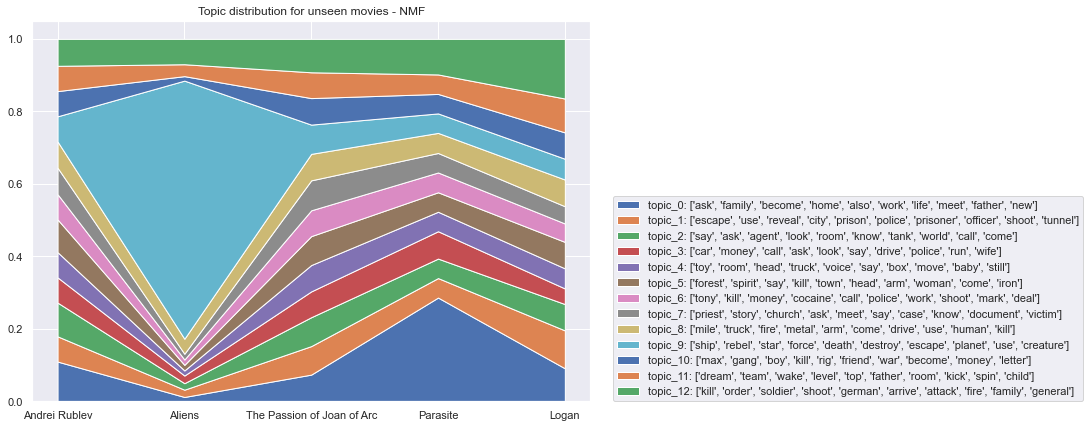

In [41]:
x_axis = list(movies_new_df['title'])
y_axis = scipy.special.softmax(movie_topic_nmf, axis=1)
fig, ax = plt.subplots(figsize=(10, 7))
ax.stackplot(x_axis, y_axis.T, baseline='zero', labels=labels_nmf)
plt.title('Topic distribution for unseen movies - NMF')
# Move the legend off of the chart
ax.legend(loc=(1.04, 0));